<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Activity Classifier - Backpack

In this notebook, we build a dense neural net to classify PE activity.

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb # new!  # delete later
from tensorflow.keras.preprocessing.sequence import pad_sequences #new!
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding # new!
from tensorflow.keras.callbacks import ModelCheckpoint # new! 
from sklearn.metrics import confusion_matrix
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # new!

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4780549353514398062
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8654014250184889757
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12340832224215731489
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2868308165831384506
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


'2.3.1'

#### Set hyperparameters

In [3]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# encoder.fit(label_array)
# encoder.categories_

# label_array.shape

In [4]:
# output directory name:
output_dir = 'model_output/dense'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/backpack/'
input_file_name = 'backpack-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency




# convolutional layer architecture:
n_conv = 64 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

# training:
epochs = 30
batch_size = 128


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [5]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [6]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [7]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
print(class_list)

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

['Lying' 'Running 3 METs' 'Running 5 METs' 'Running 7 METs'
 'Self Pace walk' 'Sitting']


array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [8]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
input_shape = list(accel_array.shape)


#### Design neural network architecture

In [9]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv, k_conv, activation='relu', input_shape=input_shape[1:]))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_class, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 64)            640       
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

### Splitting and shuffeling the data

In [11]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [13]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [14]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
import tensorflow as tf
tf.test.gpu_device_name()
tf.__version__
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((58290, 90, 3), (58290, 6), (6477, 90, 3), (6477, 6))

#### Train!

In [16]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/30
456/456 [==============================] - 2s 4ms/step - loss: 0.8477 - accuracy: 0.7072 - val_loss: 0.6533 - val_accuracy: 0.7738
Epoch 2/30
456/456 [==============================] - 2s 4ms/step - loss: 0.5593 - accuracy: 0.8281 - val_loss: 0.5328 - val_accuracy: 0.8329
Epoch 3/30
456/456 [==============================] - 2s 4ms/step - loss: 0.4662 - accuracy: 0.8602 - val_loss: 0.4532 - val_accuracy: 0.8584
Epoch 4/30
456/456 [==============================] - 2s 3ms/step - loss: 0.4273 - accuracy: 0.8714 - val_loss: 0.4405 - val_accuracy: 0.8683
Epoch 5/30
456/456 [==============================] - 2s 4ms/step - loss: 0.4007 - accuracy: 0.8785 - val_loss: 0.4630 - val_accuracy: 0.8526
Epoch 6/30
456/456 [==============================] - 2s 3ms/step - loss: 0.3837 - accuracy: 0.8819 - val_loss: 0.4107 - val_accuracy: 0.8720
Epoch 7/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3700 - accuracy: 0.8853 - val_loss: 0.4406 - val_accuracy: 0.8570
Epoch 

In [17]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


#### Evaluate

In [18]:
# model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [19]:
y_hat = model.predict(x_valid)

In [20]:
len(y_hat)

6477

In [21]:
y_hat[0]

array([5.8370392e-07, 1.9195387e-07, 9.9647409e-01, 1.9991630e-05,
       1.7184492e-11, 3.5051440e-03], dtype=float32)

In [22]:
y_valid[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

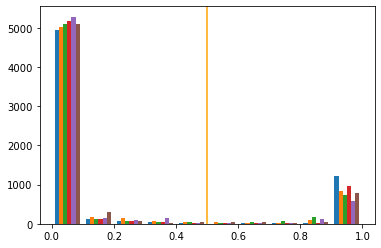

In [23]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [24]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [25]:
"{:0.2f}".format(pct_auc)

'98.97'

In [26]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [27]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [28]:
ydf.head(10)


,y_hat,y
0,5.837039e-07,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,1.679346e-01,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,1.476712e-04,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,1.804457e-01,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,9.842311e-01,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,1.416181e-06,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,1.115602e-08,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,1.665647e-10,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
8,1.438423e-03,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
9,7.426243e-02,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [29]:
# cf_matrix = confusion_matrix(y_valid, y_hat)
# print(cf_matrix) # doesn't work coz we have probability not class
y_hat

array([[5.8370392e-07, 1.9195387e-07, 9.9647409e-01, 1.9991630e-05,
        1.7184492e-11, 3.5051440e-03],
       [1.6793463e-01, 2.3752253e-03, 6.9613177e-01, 6.1335403e-02,
        3.3543452e-05, 7.2189339e-02],
       [1.4767116e-04, 6.4422220e-06, 9.7062230e-01, 1.2155414e-02,
        6.3911187e-08, 1.7068159e-02],
       ...,
       [6.7345709e-02, 6.9809542e-03, 2.7729795e-06, 8.2543898e-05,
        9.2473626e-01, 8.5182849e-04],
       [1.6799392e-02, 3.4047732e-01, 1.0598983e-01, 4.1545827e-02,
        3.1932685e-01, 1.7586084e-01],
       [2.0980628e-03, 3.2355268e-03, 8.6758380e-05, 2.8773642e-05,
        9.9213469e-01, 2.4161234e-03]], dtype=float32)

In [30]:
# convert probability to class
y_pred_class = np.argmax(y_hat, axis=1)
y_class = np.argmax(y_valid, axis = 1)

array([[1248,   60,    1,   10,   61,   21],
       [   9,  959,   18,    3,   54,   19],
       [   6,   26, 1013,   25,    6,   12],
       [  12,    6,   32, 1025,    5,    6],
       [  21,   33,    8,    7,  742,   27],
       [  23,   15,   54,    4,   14,  892]], dtype=int64)

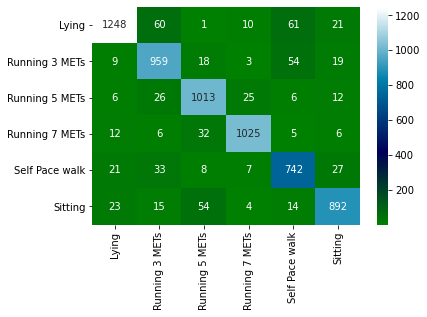

In [31]:
cf_matrix = confusion_matrix(y_class, y_pred_class, labels=range(6))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt = '1', xticklabels=class_list, yticklabels=class_list, cmap='ocean')
cf_matrix